# Using the [Open EEMeter](http://www.openeemeter.org/) library for change point models

- Clayton Miller (miller.clayton@gmail.com)
- http://datadrivenbuilding.org/

In [29]:
from __future__ import division
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import string
from datetime import datetime
import timeit
import os

In [30]:
from datetime import timedelta
#import eemeter
# models to build efficiency meters
from eemeter.importers import import_pandas
from eemeter.weather import GSODWeatherSource
from eemeter.weather import TMY3WeatherSource
#from eemeter.consumption import DatetimePeriod
from eemeter.consumption import ConsumptionData
from eemeter.weather import WeatherSourceBase
#from eemeter.consumption import ConsumptionHistory
from eemeter.models import AverageDailyTemperatureSensitivityModel
from eemeter.meter import TemperatureSensitivityParameterOptimizationMeter
from eemeter.meter import AnnualizedUsageMeter

In [31]:
sns.set_style("whitegrid")

In [32]:
%matplotlib inline

First, get the raw data:

In [33]:
repos_path = "/Users/Clayton/temporal-features-for-buildings/"

In [34]:
meta = pd.read_csv(os.path.join(repos_path,"data/raw/meta_open.csv"), index_col='uid', parse_dates=["datastart","dataend"], dayfirst=True)

In [35]:
temp = pd.read_csv((os.path.join(repos_path,"data/interim/temp_open_utc_complete.csv")), index_col='timestamp', parse_dates=True).tz_localize('utc')

## First, let's just test one building to understand the library's output and how it works

In [8]:
testbuilding = "PrimClass_Everett"

In [9]:
test_timezone = meta.T[testbuilding].timezone
test_start = meta.T[testbuilding].datastart
test_end = meta.T[testbuilding].dataend
test_building_data = pd.DataFrame(temp[testbuilding].tz_convert(test_timezone).truncate(before=test_start,after=test_end))

In [10]:
test_start#.to_datetime()

Timestamp('2012-01-01 00:00:00')

In [11]:
test_end

Timestamp('2012-12-31 23:00:00')

In [12]:
test_timezone

'America/New_York'

In [13]:
test_building_data.tail()

,PrimClass_Everett
timestamp,
2012-12-31 19:00:00-05:00,2.1675
2012-12-31 20:00:00-05:00,2.1125
2012-12-31 21:00:00-05:00,2.0325
2012-12-31 22:00:00-05:00,1.8975
2012-12-31 23:00:00-05:00,1.8600


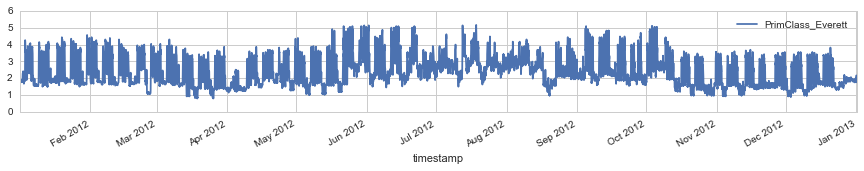

In [14]:
test_building_data.plot(figsize=(15,2));

In [15]:
weatherfilename = meta.T[testbuilding].newweatherfilename

In [16]:
weatherfilename

'weather12.csv'

In [17]:
test_weather = pd.read_csv(os.path.join(repos_path,"data/external/weather/"+weatherfilename),index_col='timestamp', parse_dates=True, na_values='-9999')
test_weather = test_weather.tz_localize(test_timezone, ambiguous = 'infer')

In [18]:
test_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10573 entries, 2012-01-01 00:53:00-05:00 to 2012-12-31 23:53:00-05:00
Data columns (total 16 columns):
Conditions               10573 non-null object
DateUTC<br />            10573 non-null object
Dew PointC               10571 non-null float64
Events                   1440 non-null object
Gust SpeedKm/h           10573 non-null object
Humidity                 10571 non-null float64
Precipitationmm          1888 non-null float64
Sea Level PressurehPa    10572 non-null float64
TemperatureC             10571 non-null float64
TimeEDT                  6967 non-null object
TimeEST                  3606 non-null object
VisibilityKm             10569 non-null float64
Wind Direction           10573 non-null object
Wind SpeedKm/h           10571 non-null object
WindDirDegrees           10573 non-null int64
timestamp.1              10573 non-null object
dtypes: float64(6), int64(1), object(9)
memory usage: 1.4+ MB


In [19]:
outdoor_temp = pd.DataFrame(test_weather[[col for col in test_weather.columns if 'Temperature' in col]]).resample("H").mean()

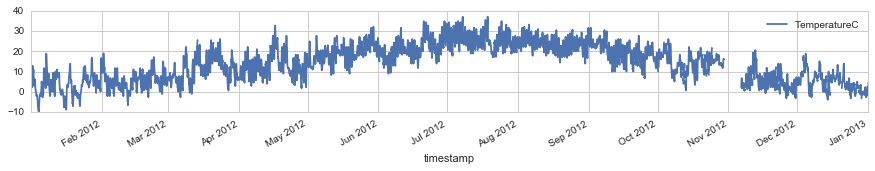

In [20]:
outdoor_temp.plot(figsize=(15,2));

In [21]:
class CustomDailyWeatherSource(WeatherSourceBase):
        def __init__(self, weather):
            data = {}
            #df = pd.read_csv("Weather/"+weatherfilename, index_col='timestamp', parse_dates=True, na_values='-9999')
            df_DB = pd.DataFrame(weather[[col for col in weather.columns if 'Temperature' in col]])
            #df_DB = (df_DB*(9/5))+32 #convert to F
            df_DB = df_DB[df_DB<120].resample("D").mean()
            df_DB = df_DB.tz_localize(None)
            for i, v in zip(df_DB.index.strftime('%Y%m%d'),list(df_DB.TemperatureC)):
                data[i] = v
            self.data = data
            self._internal_unit = "degC"

        def internal_unit_datetime_average_temperature(self,dt):
            return self.data.get(dt.strftime("%Y%m%d"),np.nan)

In [22]:
weatherdata = CustomDailyWeatherSource(test_weather)

In [23]:
#weatherdata.data

In [24]:
df_t = pd.Series(weatherdata.data)
df_t.index = df_t.index.to_datetime()
df_t = pd.DataFrame(df_t)
df_t.columns = ["TempC"]

In [25]:
df_t.head()

,TempC
2012-01-01,8.675000
2012-01-02,3.825000
2012-01-03,-3.150000
2012-01-04,-5.333333
2012-01-05,0.666667


In [26]:
model = AverageDailyTemperatureSensitivityModel(
            heating=True,
            cooling=True,
            initial_params={
                "base_daily_consumption": 0,
                "heating_slope": 0,
                "heating_balance_temperature": 10,
                "cooling_slope": 0,
                "cooling_balance_temperature": 20,
            },
            param_bounds={
                "base_daily_consumption": [0,1000000],
                "heating_slope": [0,1000],
                "heating_balance_temperature": [5,16],
                "cooling_slope": [0,1000],
                "cooling_balance_temperature": [13,24],
            })

In [27]:
to_load = test_building_data.resample('D').sum().tz_localize(None)
to_load.columns = ['Consumption']
to_load['StartDateTime'] = to_load.index.format('%Y-%m-%d %H:%M:%S.%f')[1:]
end=to_load.index+timedelta(days=1)
to_load['EndDateTime'] = end.format('%Y-%m-%d %H:%M:%S.%f')[1:]
to_load['UnitofMeasure'] = 'kWh'
to_load['FuelType'] = 'electricity'
to_load['ReadingType'] = 'actual'

In [28]:
to_load = to_load.reset_index(drop=True)

In [29]:
to_load.head()

,Consumption,StartDateTime,EndDateTime,UnitofMeasure,FuelType,ReadingType
0,43.883533,2012-01-01,2012-01-02,kWh,electricity,actual
1,48.940108,2012-01-02,2012-01-03,kWh,electricity,actual
2,69.210675,2012-01-03,2012-01-04,kWh,electricity,actual
3,71.101408,2012-01-04,2012-01-05,kWh,electricity,actual
4,70.969517,2012-01-05,2012-01-06,kWh,electricity,actual


In [30]:
consumptions = import_pandas(to_load)

In [31]:
param_optimization_meter = TemperatureSensitivityParameterOptimizationMeter("degC", model)

In [32]:
annualized_usage_meter = AnnualizedUsageMeter("degC", model)

In [33]:
params = param_optimization_meter.evaluate_raw(
                    consumption_data=consumptions,
                    weather_source=weatherdata,
                    energy_unit_str="kWh")["temp_sensitivity_params"]

/Users/Clayton/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [34]:
params.to_dict()

{'base_daily_consumption': 52.424391338060168,
 'cooling_balance_temperature': 13.574070995616555,
 'cooling_slope': 1.5012921712327079,
 'heating_balance_temperature': 10.370834462208931,
 'heating_slope': 0.16909241879317916}

In [35]:
names1 = ['Baseload', 'HeatBalPtF', 'HeatSlope','CoolBalPtF','CoolSlope']
df_par = pd.DataFrame(params.to_list())
df_par['Parameter'] = index=names1
df_par.columns = ['Value', 'Parameter']
df_par = df_par.set_index('Parameter')

In [36]:
df_m = test_building_data.resample('D').sum().tz_localize(None).join(df_t.resample('1D').mean(), how='inner')

In [37]:
df_m.tail()

,PrimClass_Everett,TempC
timestamp,,
2012-12-27,45.906025,2.497143
2012-12-28,46.037933,0.226923
2012-12-29,46.257758,-0.534091
2012-12-30,44.894775,0.142308
2012-12-31,45.642833,0.419048


In [38]:
params_list = params.to_list()

In [39]:
params_list

[52.424391338060168,
 10.370834462208931,
 0.16909241879317916,
 13.574070995616555,
 1.5012921712327079]

In [40]:
df_m['model_Consumption'] = params_list[0] + params_list[2]*(np.where(df_m.TempC<params_list[1], params_list[1]-df_m.TempC, 0)) + params_list[4]*(np.where(df_m.TempC>params_list[3], df_m.TempC - params_list[3], 0))

In [41]:
df_m['modelbase'] = params_list[0]
df_m['modelheating'] = params_list[1]*(np.where(df_m.TempC<params_list[2], params_list[2]-df_m.TempC, np.nan))
df_m['modelcooling'] = params_list[3]*(np.where(df_m.TempC>params_list[4], df_m.TempC - params_list[4], np.nan))
df_par.loc['totalNMBE'] = 100*((df_m[testbuilding] - df_m.model_Consumption).sum()/((df_m[testbuilding].count()-1) * df_m[testbuilding].mean()))
df_par.loc['totalCVRMSE'] = 100*((((df_m[testbuilding] - df_m.model_Consumption)**2).sum()/(df_m[testbuilding].count()-1))**(0.5))/df_m[testbuilding].mean()

In [42]:
df_m.head()

,PrimClass_Everett,TempC,model_Consumption,modelbase,modelheating,modelcooling
timestamp,,,,,,
2012-01-01,43.883533,8.675000,52.711144,52.424391,NaN,97.376419
2012-01-02,48.940108,3.825000,53.531242,52.424391,NaN,31.542175
2012-01-03,69.210675,-3.150000,54.710662,52.424391,34.421758,NaN
2012-01-04,71.101408,-5.333333,55.079847,52.424391,57.064747,NaN
2012-01-05,70.969517,0.666667,54.065293,52.424391,NaN,NaN


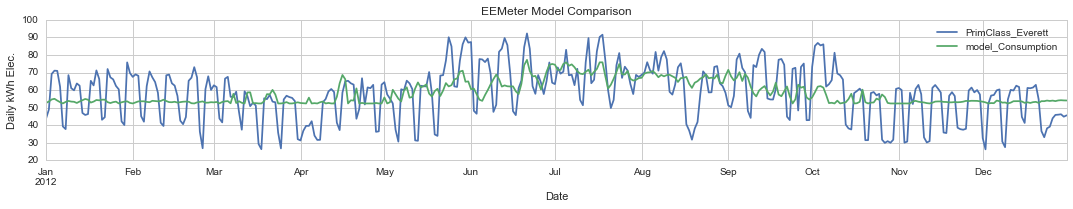

In [43]:
df_m[[testbuilding,"model_Consumption"]].plot(figsize=(15,3))
plt.xlabel("Date")
plt.ylabel("Daily kWh Elec.")
plt.title("EEMeter Model Comparison")
plt.tight_layout()
plt.savefig(os.path.join(repos_path,"reports/figures/eemeter/predictedvsactual_annual.png"));

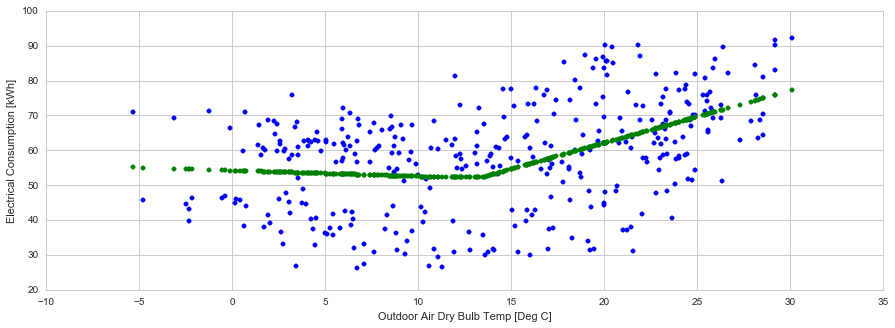

In [44]:
# sns.set_context("talk")
sns.set_style('whitegrid')
plt.figure(figsize=(15,5))
plt.scatter(df_m.TempC, df_m[testbuilding], color='b')
plt.scatter(df_m.TempC, df_m.model_Consumption, color='g')
plt.ylabel("Electrical Consumption [kWh]")
plt.xlabel("Outdoor Air Dry Bulb Temp [Deg C]")
plt.savefig(os.path.join(repos_path,"reports/figures/eemeter/changepointscatter_example.png"))
plt.show()

In [45]:
df_par

,Value
Parameter,
Baseload,52.424391
HeatBalPtF,10.370834
HeatSlope,0.169092
CoolBalPtF,13.574071
CoolSlope,1.501292
totalNMBE,-0.158667
totalCVRMSE,23.218157


# Loop through all buildings and run model

In [46]:
def runeemetermodel(meta, temp, building, model):
    
    timezone = meta.T[building].timezone
    start = meta.T[building].datastart
    end = meta.T[building].dataend
    building_data = pd.DataFrame(temp[building].tz_convert(timezone).truncate(before=start,after=end))
    
    weatherfilename = meta.T[building].newweatherfilename
    
    weather = pd.read_csv(os.path.join(repos_path,"data/external/weather/"+weatherfilename),index_col='timestamp', parse_dates=True, na_values='-9999')
    weather = weather.tz_localize(timezone, ambiguous = 'infer')
    
    weatherdata = CustomDailyWeatherSource(weather)
    df_t = pd.Series(weatherdata.data)
    df_t.index = df_t.index.to_datetime()
    df_t = pd.DataFrame(df_t)
    
    df_t.columns = ["TempC"]

    to_load = building_data.resample('D').sum().tz_localize(None)
    to_load.columns = ['Consumption']
    to_load['StartDateTime'] = to_load.index.format('%Y-%m-%d %H:%M:%S.%f')[1:]
    end=to_load.index+timedelta(days=1)
    to_load['EndDateTime'] = end.format('%Y-%m-%d %H:%M:%S.%f')[1:]
    to_load['UnitofMeasure'] = 'kWh'
    to_load['FuelType'] = 'electricity'
    to_load['ReadingType'] = 'actual'
    to_load = to_load.reset_index(drop=True)
    consumptions = import_pandas(to_load)
    
    param_optimization_meter = TemperatureSensitivityParameterOptimizationMeter("degC",model)
    annualized_usage_meter = AnnualizedUsageMeter("degC",model)
    params = param_optimization_meter.evaluate_raw(
                        consumption_data=consumptions,
                        weather_source=weatherdata,
                        energy_unit_str="kWh")["temp_sensitivity_params"]

    names1 = ['Baseload', 'HeatBalPtF', 'HeatSlope','CoolBalPtF','CoolSlope']
    df_par = pd.DataFrame(params.to_list())
    df_par['Parameter'] = index=names1
    df_par.columns = ['Value', 'Parameter']
    df_par = df_par.set_index('Parameter')
    
    df_m = building_data.resample('D').sum().tz_localize(None).join(df_t.resample('1D').mean(), how='inner')
    params_list = params.to_list()

    df_m['model_Consumption'] = params_list[0] + params_list[2]*(np.where(df_m.TempC<params_list[1], params_list[1]-df_m.TempC, 0)) + params_list[4]*(np.where(df_m.TempC>params_list[3], df_m.TempC - params_list[3], 0))
    df_m['modelbase'] = params_list[0]
    df_m['modelheating'] = params_list[2]*(np.where(df_m.TempC<params_list[1], params_list[1]-df_m.TempC, np.nan))
    df_m['modelcooling'] = params_list[4]*(np.where(df_m.TempC>params_list[3], df_m.TempC - params_list[3], np.nan))
    
    df_par.loc['totalNMBE'] = 100*((df_m[building] - df_m.model_Consumption).sum()/((df_m[building].count()-1) * df_m[building].mean()))
    df_par.loc['totalCVRMSE'] = 100*((((df_m[building] - df_m.model_Consumption)**2).sum()/(df_m[building].count()-1))**(0.5))/df_m[building].mean()
    
    return df_m, df_par

## Test on one building

In [47]:
building = "PrimClass_Everett"

In [48]:
df_m, df_par = runeemetermodel(meta, temp, building, model)

In [49]:
df_m.head()

,PrimClass_Everett,TempC,model_Consumption,modelbase,modelheating,modelcooling
timestamp,,,,,,
2012-01-01,43.883533,8.675000,52.711144,52.424391,0.286753,NaN
2012-01-02,48.940108,3.825000,53.531242,52.424391,1.106851,NaN
2012-01-03,69.210675,-3.150000,54.710662,52.424391,2.286271,NaN
2012-01-04,71.101408,-5.333333,55.079847,52.424391,2.655456,NaN
2012-01-05,70.969517,0.666667,54.065293,52.424391,1.640901,NaN


In [50]:
df_par

,Value
Parameter,
Baseload,52.424391
HeatBalPtF,10.370834
HeatSlope,0.169092
CoolBalPtF,13.574071
CoolSlope,1.501292
totalNMBE,-0.158667
totalCVRMSE,23.218157


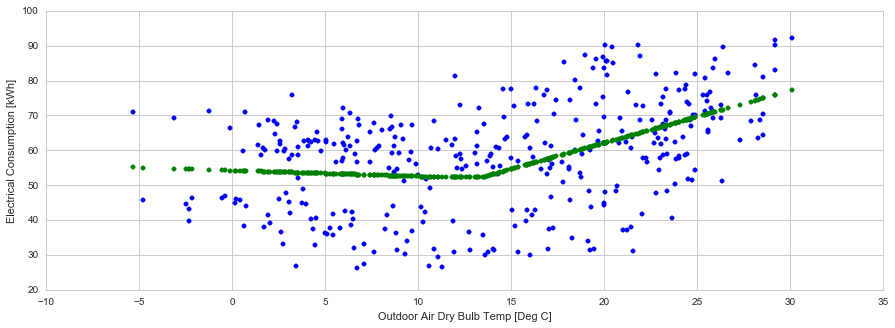

In [51]:
# sns.set_context("talk")
sns.set_style('whitegrid')
plt.figure(figsize=(15,5))
plt.scatter(df_m.TempC, df_m[building], color='b')
plt.scatter(df_m.TempC, df_m.model_Consumption, color='g')
plt.ylabel("Electrical Consumption [kWh]")
plt.xlabel("Outdoor Air Dry Bulb Temp [Deg C]")
plt.savefig(os.path.join(repos_path,"reports/figures/eemeter/changepointscatter_example.png"))
plt.show()

In [52]:
df_m.head()

,PrimClass_Everett,TempC,model_Consumption,modelbase,modelheating,modelcooling
timestamp,,,,,,
2012-01-01,43.883533,8.675000,52.711144,52.424391,0.286753,NaN
2012-01-02,48.940108,3.825000,53.531242,52.424391,1.106851,NaN
2012-01-03,69.210675,-3.150000,54.710662,52.424391,2.286271,NaN
2012-01-04,71.101408,-5.333333,55.079847,52.424391,2.655456,NaN
2012-01-05,70.969517,0.666667,54.065293,52.424391,1.640901,NaN


In [53]:
df_par

,Value
Parameter,
Baseload,52.424391
HeatBalPtF,10.370834
HeatSlope,0.169092
CoolBalPtF,13.574071
CoolSlope,1.501292
totalNMBE,-0.158667
totalCVRMSE,23.218157


# Implement on all buildings

In [54]:
buildinglist = list(meta.index)

In [68]:
temp_modelconsumption = pd.DataFrame()
temp_modelheating = pd.DataFrame()
temp_modelcooling = pd.DataFrame()
features_eemeter = pd.DataFrame()

overall_start_time = timeit.default_timer()
for building in buildinglist:
    start_time = timeit.default_timer()
    try:
        df_m, df_par = runeemetermodel(meta, temp, building, model)
    except:
        print "Couldn't model: "+building
        
    temp_modelconsumption = pd.merge(temp_modelconsumption, pd.DataFrame({building:df_m["model_Consumption"]}), right_index=True, left_index=True, how='outer')
    temp_modelheating = pd.merge(temp_modelheating, pd.DataFrame({building:df_m["modelheating"]}), right_index=True, left_index=True, how='outer')
    temp_modelcooling = pd.merge(temp_modelcooling, pd.DataFrame({building:df_m["modelcooling"]}), right_index=True, left_index=True, how='outer')
    features_eemeter = pd.merge(features_eemeter, pd.DataFrame({building:df_par["Value"]}), right_index=True, left_index=True, how='outer')
    
    print "Calculated: "+building+" in "+str(timeit.default_timer() - start_time)+" seconds"

print "Calculated all building in "+str(timeit.default_timer() - overall_start_time)+" seconds"


Calculated: PrimClass_Everett in 9.51724505424 seconds
Calculated: UnivClass_Clifford in 10.8948161602 seconds
Calculated: Office_Elizabeth in 9.59676599503 seconds
Calculated: Office_Ellie in 9.20081782341 seconds
Calculated: PrimClass_Elisabeth in 2.18929815292 seconds
Calculated: Office_Cristina in 3.3053958416 seconds
Calculated: PrimClass_Jolie in 15.124243021 seconds
Calculated: PrimClass_Jaylin in 14.3581869602 seconds
Calculated: Office_Jesus in 1.75356912613 seconds
Calculated: PrimClass_Esmeralda in 2.28658509254 seconds
Calculated: PrimClass_Eoghan in 2.0539059639 seconds
Calculated: PrimClass_Edwin in 2.99088597298 seconds
Calculated: PrimClass_Eli in 1.87267589569 seconds
Calculated: PrimClass_Ethel in 1.31783604622 seconds
Calculated: PrimClass_Ernesto in 2.33811402321 seconds
Calculated: PrimClass_Emanuela in 3.72779202461 seconds
Calculated: PrimClass_Emilio in 8.99851202965 seconds
Calculated: PrimClass_Eleanor in 3.28736996651 seconds
Calculated: PrimClass_Ezekiel in 

```

```

In [69]:
temp_modelconsumption.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1706 entries, 2010-01-01 to 2015-12-31
Columns: 507 entries, PrimClass_Everett to UnivLab_Aoife
dtypes: float64(507)
memory usage: 6.6 MB


In [70]:
temp_modelheating.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1706 entries, 2010-01-01 to 2015-12-31
Columns: 507 entries, PrimClass_Everett to UnivLab_Aoife
dtypes: float64(507)
memory usage: 6.6 MB


In [71]:
temp_modelcooling.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1706 entries, 2010-01-01 to 2015-12-31
Columns: 507 entries, PrimClass_Everett to UnivLab_Aoife
dtypes: float64(507)
memory usage: 6.6 MB


In [73]:
features_eemeter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7 entries, Baseload to totalCVRMSE
Columns: 507 entries, PrimClass_Everett to UnivLab_Aoife
dtypes: float64(507)
memory usage: 27.8+ KB


In [74]:
temp_modelconsumption.to_csv(os.path.join(repos_path,"data/interim/temp_eemeter_predictedtotal.csv"))
temp_modelheating.to_csv(os.path.join(repos_path,"data/interim/temp_eemeter_predictedheating.csv"))
temp_modelcooling.to_csv(os.path.join(repos_path,"data/interim/temp_eemeter_predictedcooling.csv"))
features_eemeter.to_csv(os.path.join(repos_path,"data/processed/features_eemeter.csv"))

# Reload and standardize output of features

In [47]:
temp_modelheating = pd.read_csv(os.path.join(repos_path,"data/interim/temp_eemeter_predictedheating.csv"), index_col='timestamp')
temp_modelcooling = pd.read_csv(os.path.join(repos_path,"data/interim/temp_eemeter_predictedcooling.csv"), index_col='timestamp')


In [48]:
temp_modelheating/meta.sqm

,PrimClass_Everett,UnivClass_Clifford,Office_Elizabeth,Office_Ellie,PrimClass_Elisabeth,Office_Cristina,PrimClass_Jolie,PrimClass_Jaylin,Office_Jesus,PrimClass_Esmeralda,...,Office_Pauline,UnivLab_Dianna,UnivDorm_Cecilia,Office_Luann,Office_Milton,Office_Lane,Office_Cameron,UnivLab_Lea,UnivLab_Carlos,UnivLab_Aoife
timestamp,,,,,,,,,,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
temp_modelheating = temp_modelheating/meta.sqm
temp_modelcooling = temp_modelcooling/meta.sqm

In [51]:
temp_modelcooling = temp_modelcooling.describe().T
temp_modelheating = temp_modelheating.describe().T

In [53]:
temp_modelcooling = temp_modelcooling[['mean','std','min','max']]
temp_modelheating = temp_modelheating[['mean','std','min','max']]


In [54]:
temp_modelcooling.columns = ['BG_eemeter_cooling_mean','BG_eemeter_cooling_std','BG_eemeter_cooling_min','BG_eemeter_cooling_max']
temp_modelheating.columns = ['BG_eemeter_heating_mean','BG_eemeter_heating_std','BG_eemeter_heating_min','BG_eemeter_heating_max']

In [56]:
features_eemeter = pd.read_csv(os.path.join(repos_path,"data/processed/features_eemeter.csv"), index_col='building_name')

In [60]:
features_eemeter_2 = pd.concat([temp_modelcooling, temp_modelheating, features_eemeter], axis=1)

In [62]:
features_eemeter_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 507 entries, PrimClass_Everett to UnivLab_Aoife
Data columns (total 15 columns):
BG_eemeter_cooling_mean    506 non-null float64
BG_eemeter_cooling_std     494 non-null float64
BG_eemeter_cooling_min     506 non-null float64
BG_eemeter_cooling_max     506 non-null float64
BG_eemeter_heating_mean    502 non-null float64
BG_eemeter_heating_std     478 non-null float64
BG_eemeter_heating_min     502 non-null float64
BG_eemeter_heating_max     502 non-null float64
BG_eemeter_baseload        507 non-null float64
BG_eemeter_heatbalpt       507 non-null float64
BG_eemeter_heatslope       507 non-null float64
BG_eemeter_coolbalpt       507 non-null float64
BG_eemeter_coolslope       507 non-null float64
BG_eemeter_nmbe            507 non-null float64
BG_eemeter_cvrmse          507 non-null float64
dtypes: float64(15)
memory usage: 63.4+ KB


In [70]:
features_eemeter_2 = features_eemeter_2.fillna(0)

In [72]:
features_eemeter_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 507 entries, PrimClass_Everett to UnivLab_Aoife
Data columns (total 15 columns):
BG_eemeter_cooling_mean    507 non-null float64
BG_eemeter_cooling_std     507 non-null float64
BG_eemeter_cooling_min     507 non-null float64
BG_eemeter_cooling_max     507 non-null float64
BG_eemeter_heating_mean    507 non-null float64
BG_eemeter_heating_std     507 non-null float64
BG_eemeter_heating_min     507 non-null float64
BG_eemeter_heating_max     507 non-null float64
BG_eemeter_baseload        507 non-null float64
BG_eemeter_heatbalpt       507 non-null float64
BG_eemeter_heatslope       507 non-null float64
BG_eemeter_coolbalpt       507 non-null float64
BG_eemeter_coolslope       507 non-null float64
BG_eemeter_nmbe            507 non-null float64
BG_eemeter_cvrmse          507 non-null float64
dtypes: float64(15)
memory usage: 63.4+ KB


In [75]:
features_eemeter_2.index.name = "building_name"
features_eemeter_2.columns.name = "feature_name"

In [76]:
features_eemeter_2.to_csv(os.path.join(repos_path,"data/processed/features_eemeter.csv"))

In [77]:
features_eemeter_2

feature_name,BG_eemeter_cooling_mean,BG_eemeter_cooling_std,BG_eemeter_cooling_min,BG_eemeter_cooling_max,BG_eemeter_heating_mean,BG_eemeter_heating_std,BG_eemeter_heating_min,BG_eemeter_heating_max,BG_eemeter_baseload,BG_eemeter_heatbalpt,BG_eemeter_heatslope,BG_eemeter_coolbalpt,BG_eemeter_coolslope,BG_eemeter_nmbe,BG_eemeter_cvrmse
building_name,,,,,,,,,,,,,,,
PrimClass_Everett,0.001112,0.000633,4.714034e-10,0.002532,0.000095,0.000059,1.946994e-11,0.000271,52.424391,10.370834,0.169092,13.574071,1.501292,-1.586672e-01,23.218157
UnivClass_Clifford,0.000000,0.000000,0.000000e+00,0.000000,0.000249,0.000176,5.192678e-06,0.000673,33.812684,5.174999,0.146261,22.583017,0.000000,-2.761312e-04,7.659764
Office_Elizabeth,0.001628,0.001177,2.163858e-05,0.005353,0.000000,0.000000,0.000000e+00,0.000000,201.821324,6.627705,0.000000,17.941176,18.005376,2.371925e-02,40.219131
Office_Ellie,0.000862,0.000644,3.108691e-05,0.003293,0.001829,0.001014,4.119879e-06,0.004572,314.872645,12.709567,15.085580,13.225003,12.746788,2.352968e-02,29.442324
PrimClass_Elisabeth,0.000753,0.000435,7.594635e-07,0.001697,0.000000,0.000000,0.000000e+00,0.000000,177.402500,7.411371,0.000000,13.000000,1.932173,6.301709e-06,41.126214
Office_Cristina,0.000000,0.000000,0.000000e+00,0.000000,0.001114,0.000772,7.962176e-06,0.003003,73.410992,16.000000,0.731291,24.000000,0.000000,1.260239e-06,15.602431
PrimClass_Jolie,0.004988,0.001031,4.258477e-03,0.005717,0.002341,0.001462,8.075636e-06,0.006000,24.378447,16.000000,1.134595,18.583333,8.195877,1.297507e-03,58.754747
PrimClass_Jaylin,0.007978,0.001650,6.811673e-03,0.009144,0.001939,0.001211,6.689536e-06,0.004970,45.654616,16.000000,1.404160,18.583333,19.586265,2.137815e-04,49.504594
Office_Jesus,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,44.899604,8.960185,0.000000,20.016852,0.000000,1.967130e-06,27.529515


In [15]:
features_eemeter = features_eemeter.T

In [17]:
features_eemeter.head()

Parameter,Baseload,HeatBalPtF,HeatSlope,CoolBalPtF,CoolSlope,totalNMBE,totalCVRMSE
PrimClass_Everett,52.424391,10.370834,0.169092,13.574071,1.501292,-0.158667,23.218157
UnivClass_Clifford,33.812684,5.174999,0.146261,22.583017,0.000000,-0.000276,7.659764
Office_Elizabeth,201.821324,6.627705,0.000000,17.941176,18.005376,0.023719,40.219131
Office_Ellie,314.872645,12.709567,15.085580,13.225003,12.746788,0.023530,29.442324
PrimClass_Elisabeth,177.402500,7.411371,0.000000,13.000000,1.932173,0.000006,41.126214


In [18]:
features_eemeter.index.name = "building_name"
features_eemeter.columns.name = "feature_name"

In [21]:
list(features_eemeter.columns)

['Baseload',
 'HeatBalPtF',
 'HeatSlope',
 'CoolBalPtF',
 'CoolSlope',
 'totalNMBE',
 'totalCVRMSE']

In [22]:
features_eemeter.columns = [
 'BG_eemeter_baseload',
 'BG_eemeter_heatbalpt',
 'BG_eemeter_heatslope',
 'BG_eemeter_coolbalpt',
 'BG_eemeter_coolslope',
 'BG_eemeter_nmbe',
 'BG_eemeter_cvrmse']

In [23]:
features_eemeter

,BG_eemeter_baseload,BG_eemeter_heatbalpt,BG_eemeter_heatslope,BG_eemeter_coolbalpt,BG_eemeter_coolslope,BG_eemeter_nmbe,BG_eemeter_cvrmse
building_name,,,,,,,
PrimClass_Everett,52.424391,10.370834,0.169092,13.574071,1.501292,-1.586672e-01,23.218157
UnivClass_Clifford,33.812684,5.174999,0.146261,22.583017,0.000000,-2.761312e-04,7.659764
Office_Elizabeth,201.821324,6.627705,0.000000,17.941176,18.005376,2.371925e-02,40.219131
Office_Ellie,314.872645,12.709567,15.085580,13.225003,12.746788,2.352968e-02,29.442324
PrimClass_Elisabeth,177.402500,7.411371,0.000000,13.000000,1.932173,6.301709e-06,41.126214
Office_Cristina,73.410992,16.000000,0.731291,24.000000,0.000000,1.260239e-06,15.602431
PrimClass_Jolie,24.378447,16.000000,1.134595,18.583333,8.195877,1.297507e-03,58.754747
PrimClass_Jaylin,45.654616,16.000000,1.404160,18.583333,19.586265,2.137815e-04,49.504594
Office_Jesus,44.899604,8.960185,0.000000,20.016852,0.000000,1.967130e-06,27.529515


In [24]:
features_eemeter.to_csv(os.path.join(repos_path,"data/processed/features_eemeter.csv"))